In [1]:
from __future__ import division, print_function
import numpy as np
from scipy import interpolate,integrate,fftpack
import pyfits
import read_params
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker,gridspec,colors
from scipy.special import j1,j0,jn
def j2(z): return jn(2,z)
def j1prime(z): return 0.5*(j0(z)-j2(z))
import os,shutil,fnmatch,itertools
import dbyd2
%matplotlib inline

Lx = read_params.get_xlength()
nx = read_params.get_nx()
x = np.linspace(-Lx/2,Lx/2,nx,endpoint=False);dx=x[1]-x[0]
dt = read_params.get_dt()
k = np.fft.fftshift(np.fft.fftfreq(nx,Lx/nx)*2*np.pi)
dk = k[1]-k[0]
k_edges = np.linspace(k[0]-dk/2,k[-1]+dk/2,nx+1)

Rsun=6.95989467700E2
z,c_sound,rho = np.loadtxt(read_params.get_solarmodel(),usecols=[0,1,2],unpack=True); z=(z-1)*Rsun;c_sound/=100;

def ddz(z_profile):
    darr = dbyd2.dbyd2(np.asfortranarray(np.atleast_2d(z_profile)),1)
    dz2d = dbyd2.dbyd2(np.asfortranarray(np.atleast_2d(z)),1)
    return np.squeeze(darr/dz2d)

def fitsread(f): return np.squeeze(pyfits.getdata(f))

RDH13 = 15
kDH13 = 2*np.pi/(2*RDH13)

datadir = read_params.get_directory()

def remove_neg(x,pos):
    return '{:.1f}'.format(abs(float(x)))

## Data Misfit

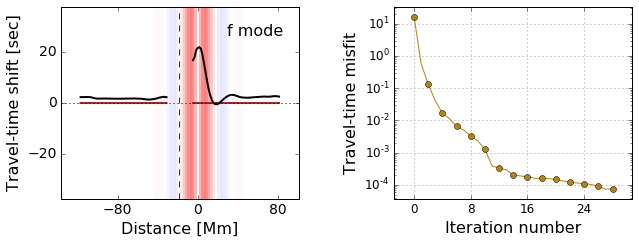

In [8]:
f=plt.figure()

src=2

datafile=os.path.join(datadir,'data',str(src).zfill(2)+'.fits')
data=fitsread(datafile)

masterpixelsfile=os.path.join(datadir,'master.pixels')
masterpixels=np.loadtxt(masterpixelsfile,ndmin=1)

def spaced(a):
    b=a[:-4]+" "+a[-4:]
    b=b.replace("_"," ")
    return b

vzcc=[]
vzcc_ridges=[]
iters=[]

srcloc=masterpixels[int(src)-1]
srcloc_ind=np.argmin(abs(x-srcloc))
srcloc=round(x[srcloc_ind],1)

modes={'0':'fmode'}
for pmodeno in xrange(1,8): modes.update({str(pmodeno):'p'+str(pmodeno)+'mode'})
ridge_filters=['0']
    
ttdiff_ridges={}
for mode in modes: ttdiff_ridges.update({mode:{"iter_no":[],"misfits":[]}})
for iteration_no in xrange(0,100):
    ttpath=os.path.join(datadir,'tt','iter'+str(iteration_no).zfill(2))
    if os.path.exists(ttpath):
        for modeno,mode in enumerate(ridge_filters):
            ttfile=os.path.join(ttpath,'ttdiff_src{:02d}.'.format(src)+modes[mode]+'.0')
            if os.path.exists(ttfile):
                ttdiff_ridges[mode]["iter_no"].append(iteration_no)
                ttdiff_ridges[mode]["misfits"].append(np.loadtxt(ttfile))
# vspans to indicate extent of flow
numspans = 40
spanedges = np.linspace(-3*RDH13,3*RDH13,numspans)
def vx_r_fn(x): return j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
vx_x = vx_r_fn(x)*np.sign(x)
norm = matplotlib.colors.Normalize(vx_x.min()*2, vx_x.max()*2)
my_cmap = matplotlib.cm.get_cmap("bwr")

# list of axes
axlist = []
c=itertools.cycle(['brown','black'])

labels=["starting","inverted"]

for modeno,mode in enumerate(ridge_filters[:8]):

    iters_to_plot_ridge = ttdiff_ridges[mode]["iter_no"]

    linestyles = itertools.cycle(('solid','dashed'))

    ax = f.add_subplot(1,2,1)
    axlist.append(ax)

    if len(iters_to_plot_ridge)>2:
        iters_to_plot_ridge= [iters_to_plot_ridge[i] for i in [-1,0]]

    for color_index,iter_no in enumerate(iters_to_plot_ridge):

        index_of_iteration=ttdiff_ridges[mode]["iter_no"].index(iter_no)
        td=ttdiff_ridges[mode]["misfits"][index_of_iteration]
        td[:,0]-=1 # fortran index starts from 1, change to python zero based index

        left_pix=np.where(td[:,0]<srcloc_ind)[0]
        xcoords_left=np.take(x,td[left_pix,0].astype(int))
        right_pix=np.where(td[:,0]>srcloc_ind)[0]
        xcoords_right=np.take(x,td[right_pix,0].astype(int))

        #~ Points to the left
        skip_pix = 1
        ls = next(linestyles)
        color = next(c)
        p=ax.plot(xcoords_left[::skip_pix],-td[left_pix[::skip_pix],1],
                color=color,label=labels[color_index],
                linestyle='solid',linewidth=2,zorder=2)[0]

        #~ Points to the right
        ax.plot(xcoords_right[::skip_pix],-td[right_pix[::skip_pix],1],
        color=p.get_color(),linestyle='solid',linewidth=2,zorder=2)

    ax.text(0.7,0.85,spaced(modes[mode]),fontdict={"size":16},transform=ax.transAxes)
    ax.axhline(y=[0],ls='dotted',color='black')
    ax.axvline(x=srcloc,color='#333333',ls='dashed')

    ax.xaxis.set_major_locator(ticker.MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5,prune='both'))
    ax.xaxis.set_tick_params(which='major', labelsize=14)
    ax.yaxis.set_tick_params(which='major', labelsize=14)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(-max(abs(ymin),abs(ymax))*1.5,max(abs(ymin),abs(ymax))*1.5)
    ax.set_ylabel("Travel-time shift [sec]",fontsize=16)
    ax.set_xlabel("Distance [Mm]",fontsize=16)

    for span_left,span_right in zip(spanedges[:-1],spanedges[1:]):
        span_color = my_cmap(norm(vx_r_fn((span_left+span_right)/2)))
        ax.axvspan(span_left,span_right,color=span_color,zorder=0)


plt.margins(x=0.1)


f.add_subplot(1,2,2)

misfitfiles=sorted([os.path.join(datadir,"update",fil) for fil in 
                    fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                                   'misfit_[0-9][0-9]')])

total_misfit = np.zeros(len(misfitfiles))
for fileno,misfitfile in enumerate(misfitfiles):
    total_misfit[fileno] = np.sum(np.loadtxt(misfitfile,usecols=[2]))
    
plotdict = dict(color='darkgoldenrod',marker='o',ls='solid',zorder=1,markevery=2)
plt.semilogy(range(len(misfitfiles)),total_misfit,**plotdict)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.ylabel('Travel-time misfit',fontsize=16)
plt.xlabel("Iteration number",fontsize=16)
plt.margins(x=0.1)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=6,integer=True,prune="lower"))
plt.ylim(min(total_misfit)/2,max(total_misfit)*2)
plt.grid(color="0.3")

f.set_size_inches(9,3.5)
f.tight_layout()
f.subplots_adjust(wspace=0.4)

savepath = os.path.join("plots","tt_misfit_fmode.eps")
if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(savepath)

## Reference and starting models

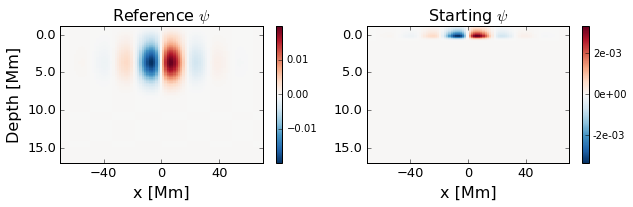

In [50]:


plt.gcf().set_size_inches(9,3);
plt.tight_layout();

savepath = os.path.join("plots","true_starting_psi.eps")
if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(savepath)

## Spline Interpolation starting

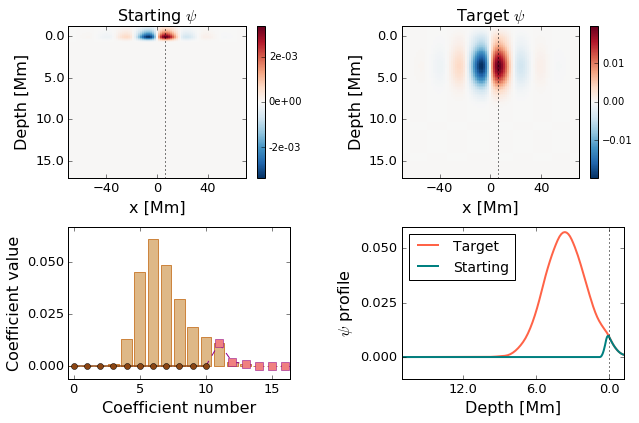

In [252]:
def coeff_to_model(tck_z):
    f0_x = np.sign(x)*j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
    h_z=interpolate.splev(z,tck_z,ext=1)
    return f0_x[None,:]*h_z[:,None]

f= dict(np.load(os.path.join(datadir,"true_psi_coeffs.npz")))
coeff_surf_cutoff_ind = f.get("c_surf_cutoff").item()
tz1D = f.get("tz")
cz1D_top = f.get("cz_top")
cz1D_bottom = f.get("cz_bot")
kz = f.get("kz")
z_cutoff = f.get("z_cutoff")

psi_spline = coeff_to_model((tz1D,cz1D_top+cz1D_bottom,kz))
psi_spline_surf = coeff_to_model((tz1D,cz1D_top,kz))

gl = plotc.gridlist(2,2)

psi_max_row,psi_max_col=np.unravel_index(psi_spline.argmax(),psi_spline.shape)

plotc.colorplot(psi_spline_surf,x=x,y=z,xr=[-70,70],yr=[z_cutoff-2,None],centerzero=True,sp=next(gl));
plt.title(r'Starting $\psi$',fontsize=16)
plt.tick_params(labelsize=13)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
plt.xlabel("x [Mm]",fontsize=16)
plt.ylabel("Depth [Mm]",fontsize=16)
plt.axvline(x[psi_max_col],ls="dotted",color="black")

plotc.colorplot(psi_spline,x=x,y=z,xr=[-70,70],yr=[z_cutoff-2,None],centerzero=True,sp=next(gl));
plt.title(r'Target $\psi$',fontsize=16)
plt.tick_params(labelsize=13)
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
plt.ylabel("Depth [Mm]",fontsize=16)
plt.xlabel("x [Mm]",fontsize=16)
plt.axvline(x[psi_max_col],ls="dotted",color="black")



plt.subplot(next(gl))

coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                "model_psi_[0-9][0-9]_coeffs.npz"))

spline_basis_coeffs = [np.load(os.path.join(datadir,"update",f)) for f in coeff_files]
spline_basis_z = [s["z"] for s in spline_basis_coeffs]

true_coeffs = np.load(os.path.join(datadir,"true_psi_coeffs.npz"))
tz = true_coeffs["tz"]
true_coeffs_z = true_coeffs["cz_bot"]
true_coeffs_top = true_coeffs["cz_top"]
c_surf_cutoff = true_coeffs['c_surf_cutoff']
kz = true_coeffs["kz"]

modenames = {'0':'f'}
for i in xrange(1,8): modenames[str(i)] = 'p{:d}'.format(i)

iterno = 0
plt.plot(spline_basis_z[iterno][:c_surf_cutoff],ls="solid",
marker="o",markersize=6,label="Iterated\ncoefficients",
color="saddlebrown",lw=1.5,zorder=4)

bridge = [spline_basis_z[iterno][c_surf_cutoff-1],true_coeffs_top[c_surf_cutoff]]

plt.plot(np.arange(c_surf_cutoff-1,c_surf_cutoff+1),
bridge,ls="dashed",color='darkmagenta',lw=1,zorder=3)

plt.plot(np.arange(c_surf_cutoff,true_coeffs_top.size),
true_coeffs_top[c_surf_cutoff:],ls="dashed",marker='s',ms=8,color='darkmagenta',
mec='darkmagenta',mfc="lightcoral",lw=1,zorder=3,
label="Coefficients\nabove surface,\nclamped")

plt.gca().margins(y=0.1)

plt.bar(np.arange(true_coeffs_z.size)-0.4,true_coeffs_z+true_coeffs_top,width=0.8,
        facecolor="burlywood",edgecolor="peru",label="Coefficients\nfor reference\nmodel"
        ,zorder=1)

plt.xlabel("Coefficient number",fontsize=16)
plt.ylabel("Coefficient value",fontsize=16)

plt.tick_params(labelsize=13)
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))

#plt.legend(loc="best")

plt.subplot(next(gl))

psi_vert_profile_full=interpolate.splev(z,(tz,true_coeffs_z+true_coeffs_top,kz),ext=0)
psi_vert_profile_top=interpolate.splev(z,(tz,true_coeffs_top,kz),ext=0)

plt.plot(z,psi_vert_profile_full,color="tomato",lw=2,label="Target")
plt.plot(z,psi_vert_profile_top,color="teal",lw=2,label="Starting")
plt.axvline(0,ls="dotted",color="black")

plt.xlim(z_cutoff-2,z[-1])
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
plt.xlabel("Depth [Mm]",fontsize=16)
plt.ylabel(r"$\psi$ profile",fontsize=16)
plt.tick_params(labelsize=13)
plt.legend(loc="best",fontsize=14)

plt.gcf().set_size_inches(9,6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/starting_model_spline.eps")

## Fitted models

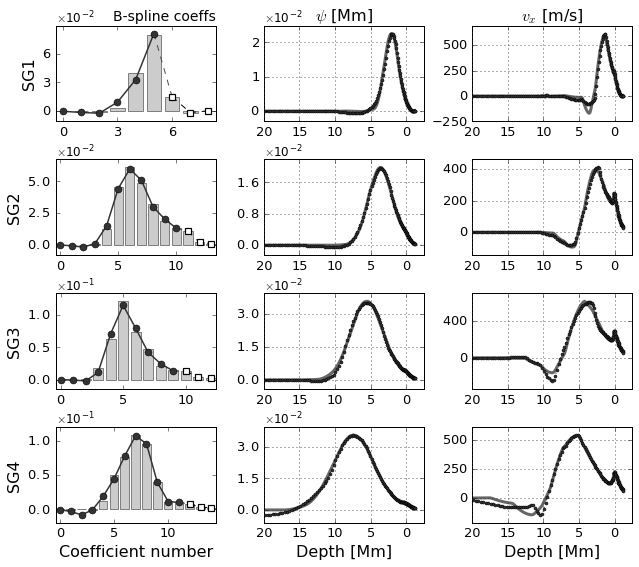

In [84]:
RDH13 = 15
kDH13 = 2*np.pi/(2*RDH13)

datadir_list = [os.path.join(os.path.dirname(read_params.get_directory()),
                             "spline_SG{:d}_filter".format(sgno)) for sgno in xrange(1,5)]

home = os.environ["HOME"]
codedir_list = [os.path.join(home,"sparc_SG{:d}".format(sgno)) for sgno in xrange(1,5)]

f=plt.figure()
f.set_size_inches(12,3*len(datadir_list));
ncols = 3

def remove_neg(x,pos):
    return '{:.0f}'.format(abs(float(x)))

for modelno,(codedir,datadir) in enumerate(zip(codedir_list,datadir_list)):
    
    plt.subplot(len(datadir_list),ncols,modelno*ncols+1)

    coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9]_coeffs.npz"))
    vx_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "vx_[0-9][0-9].fits"))

    spline_basis_coeffs = [np.load(os.path.join(datadir,"update",f)) for f in coeff_files]
    spline_basis_z = [s["z"] for s in spline_basis_coeffs]

    true_coeffs = np.load(os.path.join(datadir,"true_psi_coeffs.npz"))
    true_coeffs_z = true_coeffs["cz_bot"]
    true_coeffs_top = true_coeffs["cz_top"]
    c_surf_cutoff = true_coeffs['c_surf_cutoff']

    iterno = min(len(spline_basis_z),len(vx_files))-1

    plt.plot(spline_basis_z[iterno][:c_surf_cutoff],ls="solid",
    marker="o",markersize=7,label="Iterated",
    color="0.2",lw=1.5,zorder=4)

    bridge = [spline_basis_z[iterno][c_surf_cutoff-1],true_coeffs_top[c_surf_cutoff]]

    plt.plot(np.arange(c_surf_cutoff-1,c_surf_cutoff+1),
    bridge,ls="dashed",color='0.3',lw=1,zorder=3)

    plt.plot(np.arange(c_surf_cutoff,true_coeffs_top.size-3),
    true_coeffs_top[c_surf_cutoff:-3],ls="dashed",marker='s',ms=6,color='black',
    mec='black',mfc="white",lw=1,zorder=3,mew=1.2,
    label="Clamped")

    plt.gca().margins(y=0.1)

    plt.bar(np.arange(true_coeffs_z.size-3)-0.4,(true_coeffs_z+true_coeffs_top)[:-3],width=0.8,
            facecolor="0.8",edgecolor="0.5",label="Reference"
            ,zorder=1)   
    
    plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.tick_params(labelsize=13,axis="both")
    plt.gca().yaxis.get_offset_text().set_fontsize(12)
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0,3))
    
    # psi and v sections
    
    true_psi = fitsread(os.path.join(codedir,'true_psi.fits'))
    current_psi = fitsread(os.path.join(datadir,'update',
                    'model_psi_{:02d}.fits'.format(iterno)))
    current_psi = current_psi-current_psi[0,0]

    true_vx = fitsread(os.path.join(codedir,'true_vx.fits'))
    true_vz = fitsread(os.path.join(codedir,'true_vz.fits'))

    current_vx = fitsread(
    os.path.join(datadir,'update','vx_{:02d}.fits'.format(iterno)))

    current_vz = fitsread(
    os.path.join(datadir,'update','vz_{:02d}.fits'.format(iterno)))
    
    psi_max_row_index,psi_max_col_index = divmod(true_psi.argmax(),nx)
    curpsi_max_row_index,curpsi_max_col_index = divmod(current_psi.argmax(),nx)

    vx_max_row_index,vx_max_col_index = divmod(true_vx.argmax(),nx)
    curvx_max_row_index,curvx_max_col_index = divmod(current_vx.argmax(),nx)

    vz_max_row_index,vz_max_col_index = divmod(true_vz.argmax(),nx)
    curvz_max_row_index,curvz_max_col_index = divmod(current_vz.argmax(),nx)

    ref_color="0.4"
    iter_color="0.2"
    
    plt.subplot(len(datadir_list),ncols,modelno*ncols+2)
    plt.plot(z,true_psi[:,curpsi_max_col_index],label="Reference",
             color=ref_color,linewidth=3)
    plt.plot(z,current_psi[:,curpsi_max_col_index],label="Iterated",
    linewidth=1,color=iter_color,ls="dotted",marker='o',ms=3)
    plt.ticklabel_format(axis="y",style="sci",scilimits=(0,0))
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0,3))
    plt.tick_params(labelsize=13,axis="both")
    plt.gca().yaxis.get_offset_text().set_fontsize(12)
    plt.xlim(-20,2.5)        
    plt.margins(y=0.1)
    plt.grid(color="0.2",linewidth=0.8)

    plt.subplot(len(datadir_list),ncols,modelno*ncols+3)
    plt.plot(z,true_vx[:,curvx_max_col_index],label="Reference",
             color=ref_color,linewidth=3)
    plt.plot(z,current_vx[:,curvx_max_col_index],label="Iterated",
    linewidth=1,color=iter_color,ls="dotted",marker='o',ms=3)
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(4))
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(5))
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
    plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
    plt.gca().yaxis.get_major_formatter().set_powerlimits((0,3))
    plt.tick_params(labelsize=13,axis="both")
    plt.gca().yaxis.get_offset_text().set_fontsize(12)
    plt.xlim(-20,2.5)
    plt.margins(y=0.1)
    plt.grid(color="0.2",linewidth=0.8)

plt.subplot(len(datadir_list),ncols,1)
plt.title("B-spline coeffs",fontsize=14,loc="right")

for modelno,datadir in enumerate(datadir_list):
    plt.subplot(len(datadir_list),ncols,ncols*modelno+1)
    plt.ylabel("SG{:d}".format(modelno+1),fontsize=16)

plt.subplot(len(datadir_list),ncols,2)
plt.title(r"$\psi$ [Mm]",fontsize=16)

plt.subplot(len(datadir_list),ncols,3)
plt.title(r"$v_x$ [m/s]",fontsize=16)

plt.subplot(len(datadir_list),ncols,ncols*(len(datadir_list)-1)+1)
plt.xlabel("Coefficient number",fontsize=16)

plt.subplot(len(datadir_list),ncols,ncols*(len(datadir_list)-1)+2)
plt.xlabel("Depth [Mm]",fontsize=16)

plt.subplot(len(datadir_list),ncols,ncols*(len(datadir_list)-1)+3)
plt.xlabel("Depth [Mm]",fontsize=16)

plt.gcf().set_size_inches(9,8)
plt.tight_layout()
plt.gcf().subplots_adjust(hspace=0.4,wspace=0.3)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/all_fitted_models.eps")

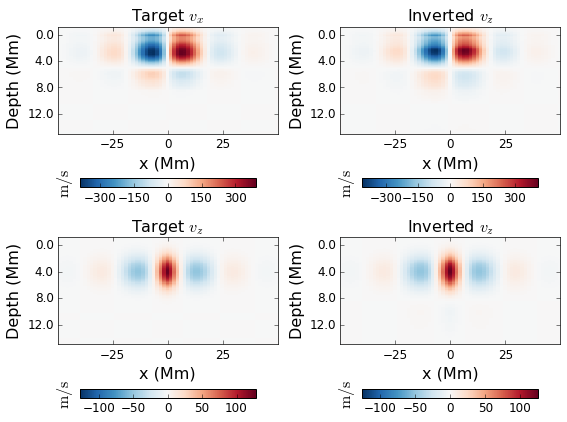

In [281]:
f=plt.figure()
f.set_size_inches(8,6)

coeff_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "model_psi_[0-9][0-9].fits"))

vx_files = sorted(fnmatch.filter(os.listdir(os.path.join(datadir,"update")),
                    "vx_[0-9][0-9].fits"))

iterno = min(len(coeff_files),len(vx_files))-1

true_vx = fitsread(os.path.join('true_vx.fits'))
true_vz = fitsread(os.path.join('true_vz.fits'))
current_vx = fitsread(os.path.join(datadir,'update','vx_{:02d}.fits'.format(iterno)))
current_vz = fitsread(os.path.join(datadir,'update','vz_{:02d}.fits'.format(iterno)))

x_plot = np.append(x-dx/2,x[-1]+dx/2)

def remove_neg(x,pos):
    return '{:.1f}'.format(abs(float(x)))

axlist = {}
cblist = {}
def add_subplot(sp_index,array,title=""):
    ax=plt.subplot(sp_index)
    array_max = abs(array).max()
    qm=ax.pcolormesh(x_plot,z,array,vmax=array_max,vmin=-array_max,cmap="RdBu_r",rasterized=True)
    cb=plt.colorbar(mappable=qm,orientation="horizontal",shrink=0.8,pad=0.25,ticks=ticker.MaxNLocator(6))
    plt.title(title,y=1.01,fontsize=16)
    ax.set_xlim(-50,50)
    ax.set_ylim(-15,z.max())
    ax.set_xlabel("x (Mm)",fontsize=16)
    ax.set_ylabel("Depth (Mm)",fontsize=16)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4,prune="both"))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(5,prune="both"))
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
    ax.tick_params(axis='both',labelsize=12)
    plt.setp(ax.spines.values(), linewidth=0.7)
    axlist[sp_index]=ax
    cblist[sp_index]=cb

add_subplot(221,true_vx,title="Target $v_x$")
add_subplot(222,current_vx,title="Inverted $v_z$")
add_subplot(223,true_vz,title="Target $v_z$")
add_subplot(224,current_vz,title="Inverted $v_z$")
    
for cb in cblist.values(): 
    cb.ax.set_ylabel(r"$\mathrm{m}/\mathrm{s}$",rotation=90,fontsize=16)
    cb.ax.tick_params(axis="x",labelsize=12)

plt.tight_layout()
if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig("plots/true_inverted_vel.eps")

## Source with waves on flows

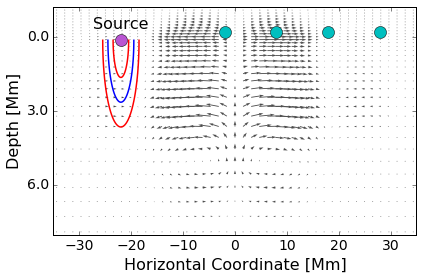

In [289]:
vx=fitsread('true_vx.fits')
vz=fitsread('true_vz.fits')

x_cutoff = 35
z_cutoff = -8

qv=plt.quiver(x[(x>-x_cutoff) & (x<x_cutoff)],z[z>-8][::3],
              vx[z>-8][::3,(x>-x_cutoff) & (x<x_cutoff)],
              vz[z>-8][::3,(x>-x_cutoff) & (x<x_cutoff)],
              scale=8000,color="0.3")

plt.xlim(-x_cutoff,x_cutoff)
plt.ylim(z_cutoff,z[-1])

plt.xlabel("Horizontal Coordinate [Mm]",fontsize=16)
plt.ylabel("Depth [Mm]",fontsize=16)

excite_depth=read_params.get_excitedepth()/1e8
obs_depth = read_params.get_obs_depth()/1e8

src=1
src_locs=np.loadtxt(os.path.join(datadir,'master.pixels'),ndmin=1)
src_x = src_locs[src-1]
plt.plot([src_x],[excite_depth],marker='o',markerfacecolor='mediumorchid',markersize=12)

wavefronts=3
wavefront_r=[1.5+1.*i for i in xrange(wavefronts)]
pts=50
wfcoords=np.zeros((wavefronts,2,pts))
thetas=np.linspace(np.pi,2*np.pi,pts)
for wfno in xrange(wavefronts):
    wfcoords[wfno,0]=wavefront_r[wfno]*np.cos(thetas)+src_x
    wfcoords[wfno,1]=wavefront_r[wfno]*np.sin(thetas)+excite_depth
    plt.plot(wfcoords[wfno,0],wfcoords[wfno,1],color=['red','blue'][wfno%2],linewidth=1.5)

rec_dist=[20,30,40,50]
for rec_x in rec_dist:
    plt.plot([rec_x+src_x],[obs_depth],marker='o',markerfacecolor='c',markersize=12,mec='black')

plt.text(src_x,0.2,"Source",horizontalalignment='center',verticalalignment='bottom',
        fontsize=16)

# plt.text(rec_x,0.4,"Receiver",horizontalalignment='center',verticalalignment='bottom',
#         fontsize=16)

ax=plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
ax.yaxis.set_major_locator(ticker.MaxNLocator(4))

plt.gcf().set_size_inches(6,4)
plt.tick_params(axis="both",labelsize=14)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(os.path.join('plots','waves_in_flow.eps'))

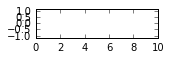

In [298]:
t_wp = np.linspace(0,10,1000)
def wavefn(t_peak):
    return np.exp(-(t_wp-t_peak)**2/(2*1**2))*np.sin(2*np.pi*(t_wp-t_peak)/0.7)

if not os.path.exists("plots"): os.makedirs("plots")

for t_peak in xrange(4,8):
    plt.plot(t_wp,wavefn(t_peak),color="black",lw=2);
    plt.margins(y=0.1);
    plt.gca().xaxis.set_major_locator(ticker.NullLocator())
    plt.gca().yaxis.set_major_locator(ticker.NullLocator())
    plt.gcf().set_size_inches(2,0.7)
    plt.tight_layout()
    plt.setp(ax.spines.values(), linewidth=0.7)
    plt.savefig(os.path.join("plots","wp_{:d}.eps".format(t_peak)))
    plt.cla();

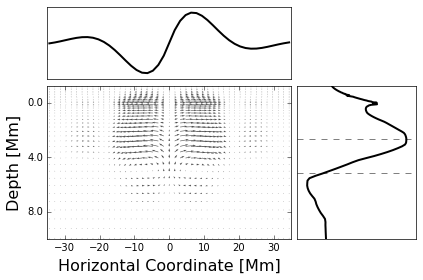

In [283]:
vx=fitsread('true_vx.fits')
vz=fitsread('true_vz.fits')

x_cutoff = 35
z_cutoff = -10

ax1=plt.subplot2grid((3,3),(0,0),colspan=2,rowspan=1)
ax2=plt.subplot2grid((3,3),(1,0),colspan=2,rowspan=2)
ax3=plt.subplot2grid((3,3),(1,2),colspan=1,rowspan=2)

qv=ax2.quiver(x[(x>-x_cutoff) & (x<x_cutoff)],z[z>z_cutoff][::3],
              vx[z>z_cutoff][::3,(x>-x_cutoff) & (x<x_cutoff)],
              vz[z>z_cutoff][::3,(x>-x_cutoff) & (x<x_cutoff)],
              scale=8000,color="0.3")

ax2.set_xlim(-x_cutoff,x_cutoff)
ax2.set_ylim(z_cutoff,z[-1])

ax2.set_xlabel("Horizontal Coordinate [Mm]",fontsize=16)
ax2.set_ylabel("Depth [Mm]",fontsize=16)

ax2.yaxis.set_major_formatter(ticker.FuncFormatter(remove_neg))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(4))

for ax in [ax1,ax3]:
    ax.xaxis.set_major_locator(ticker.NullLocator())
    ax.yaxis.set_major_locator(ticker.NullLocator())
    
ax1.plot(x[(x>-x_cutoff) & (x<x_cutoff)],
         vx[abs(z).argmin()][(x>-x_cutoff) & (x<x_cutoff)],
         lw=2,color="black")
ax1.set_xlim(ax2.get_xlim())
ax1.margins(y=0.1)

_,sg_max_col = np.unravel_index(vx.argmax(),vx.shape)
ax3.plot(vx[z>z_cutoff,sg_max_col],z[z>z_cutoff],lw=2,color="black",zorder=1)
ax3.set_ylim(ax2.get_ylim())
ax3.margins(x=0.1)
ax3.axhline(z[np.where(np.diff(np.sign(vx[:,sg_max_col])))[0][-1]],color="grey",ls="dashed",zorder=0)
ax3.axhline(z[vx[:,sg_max_col].argmax()],color="grey",ls="dashed",zorder=0)

for ax in [ax1,ax2,ax3]:
    plt.setp(ax.spines.values(), linewidth=0.7)

plt.gcf().set_size_inches(6,4)
plt.tick_params(axis="both",labelsize=14)
plt.tight_layout()
plt.subplots_adjust(wspace=0.05,hspace=0.1)

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(os.path.join('plots','supergranule_flow_field.eps'))

## Spectrum

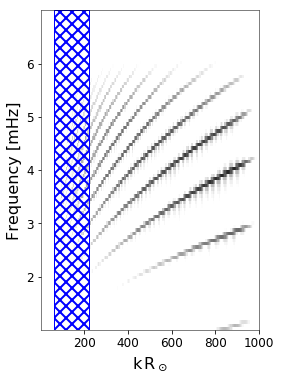

In [37]:
src=1
data = fitsread(os.path.join(datadir,"data",str(src).zfill(2)+".fits"))

nt = data.shape[0]
nu = np.fft.fftshift(np.fft.fftfreq(nt,dt))*1e3
dnu = nu[1]-nu[0]
nu_edges = np.linspace(nu[0]-dnu/2,nu[-1]+dnu/2,nt+1)

data_spec= np.fft.fftshift(abs(np.fft.fft2(data))**2)

# C = np.loadtxt('cust_cmap')
# cm = colors.ListedColormap(C/255.0)

# plt.pcolormesh(k_edges*Rsun,nu_edges,data_spec/data_spec.max(),
# cmap=cm,rasterized=True,norm=colors.LogNorm(vmin=0.005, vmax=2))

plt.pcolormesh(k_edges*Rsun,nu_edges,data_spec/data_spec.max(),
cmap='Greys',rasterized=True,norm=colors.LogNorm(vmin=0.005, vmax=2))

ax = plt.gca()

plt.xlim(0,1000)
plt.ylim(1,7)

ax.xaxis.set_major_locator(ticker.MaxNLocator(5,prune="lower"))
ax.yaxis.set_major_locator(ticker.MaxNLocator(6,prune="both"))

# matplotlib.rcParams['hatch.linewidth'] = 2
ax.axvspan(2*np.pi/75*Rsun,2*np.pi/20*Rsun,ls='solid',color="b",fill=False,hatch="x"*2)

plt.xlabel(r"$\mathrm{k\,R_\odot}$",fontsize=16,labelpad=5);
plt.ylabel(r"Frequency [mHz]",fontsize=16);

[i.set_linewidth(0.5) for i in ax.spines.itervalues()]

plt.gcf().set_size_inches(4,5.35)
plt.tick_params(labelsize=12)
plt.tick_params(axis="y",labelsize=12)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(os.path.join("plots","spectrum.eps"),dpi=100)

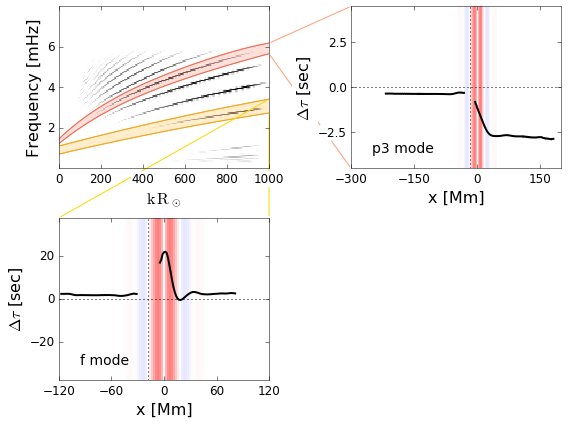

In [11]:
src=2
masterpixels=np.loadtxt(os.path.join(datadir,'master.pixels'),ndmin=1)
srcloc=masterpixels[int(src)-1];src_x=srcloc
srcloc_ind=np.argmin(abs(x-srcloc))

data = fitsread(os.path.join(datadir,"data",str(src).zfill(2)+".fits"))

nt = data.shape[0]
nu = np.fft.fftshift(np.fft.fftfreq(nt,dt))*1e3
dnu = nu[1]-nu[0]
nu_edges = np.linspace(nu[0]-dnu/2,nu[-1]+dnu/2,nt+1)

data_spec= np.fft.fftshift(abs(np.fft.fft2(data))**2)

ax1=plt.subplot(221)
ax1.set_rasterization_zorder(2)
plt.pcolormesh(k_edges*Rsun,nu_edges,data_spec/data_spec.max(),
cmap='Greys',rasterized=True,norm=colors.LogNorm(vmin=0.01, vmax=1),zorder=0)

#fmode polynomials
p_high_f = np.polyval(np.poly1d([-0.2,1.9,1.1]),k_edges)
p_low_f = np.polyval(np.poly1d([-0.2,1.7,0.7]),k_edges)

plt.plot(k_edges*Rsun,p_high_f,color="orange",zorder=2)
plt.plot(k_edges*Rsun,p_low_f,color="orange",zorder=2)
plt.fill_between(k_edges*Rsun,p_low_f,p_high_f,facecolor='orange',interpolate=True,alpha=0.2,zorder=1)

#p3mode polynomials
# p_high_p3 = np.polyval(np.poly1d([-1.638,5.286,-7.201,7.661,1.342]),k_edges)
p_high_p3 = np.polyval(np.poly1d([-0.847,3.192,-5.325,6.87,1.45]),k_edges)
p_low_p3 = np.polyval(np.poly1d([-0.387,1.9,-3.889,5.906,1.214]),k_edges)

plt.plot(k_edges*Rsun,p_high_p3,color="tomato",zorder=2)
plt.plot(k_edges*Rsun,p_low_p3,color="tomato",zorder=2)
plt.fill_between(k_edges*Rsun,p_low_p3,p_high_p3,facecolor='tomato',interpolate=True,alpha=0.2,zorder=1)

plt.xlim(0,1000)
plt.ylim(0,8)

ax1.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax1.yaxis.set_major_locator(ticker.MaxNLocator(4,prune="both"))

plt.xlabel(r"$\mathrm{k\,R_\odot}$",fontsize=16,labelpad=5);
plt.ylabel(r"Frequency [mHz]",fontsize=16);
[i.set_linewidth(0.5) for i in ax1.spines.itervalues()]
plt.tick_params(labelsize=12)
label = ax1.yaxis.get_ticklabels()+ax1.xaxis.get_ticklabels()
for l in label:
    l.set_bbox(dict(facecolor='white', edgecolor='white',pad=1))

ax2=plt.subplot(222)
td = np.loadtxt(os.path.join(datadir,"tt","iter00","ttdiff_src{:02d}.p3mode.0".format(src)))
td[:,0]-=1 # fortran index starts from 1, change to python zero based index

left_pix=np.where(td[:,0]<srcloc_ind)[0]
xcoords_left=np.take(x,td[left_pix,0].astype(int))
right_pix=np.where(td[:,0]>srcloc_ind)[0]
xcoords_right=np.take(x,td[right_pix,0].astype(int))

p=ax2.plot(xcoords_left,-td[left_pix,1],linewidth=2,zorder=2,color="black")[0]
ax2.plot(xcoords_right,-td[right_pix,1],linewidth=2,zorder=2,color="black")
ax2.axhline(0,ls="dotted",color="black")
plt.ylim(-abs(np.array(plt.ylim())).max(),abs(np.array(plt.ylim())).max())
plt.text(0.1,0.1,"p3 mode",transform=ax2.transAxes,fontdict={"size":14})

ax3=plt.subplot(223)
td = np.loadtxt(os.path.join(datadir,"tt","iter00","ttdiff_src{:02d}.fmode.0".format(src)))
td[:,0]-=1 # fortran index starts from 1, change to python zero based index

left_pix=np.where(td[:,0]<srcloc_ind)[0]
xcoords_left=np.take(x,td[left_pix,0].astype(int))
right_pix=np.where(td[:,0]>srcloc_ind)[0]
xcoords_right=np.take(x,td[right_pix,0].astype(int))

p=ax3.plot(xcoords_left,-td[left_pix,1],linewidth=2,zorder=2,color="black")[0]
ax3.plot(xcoords_right,-td[right_pix,1],linewidth=2,zorder=2,color="black")
ax3.axhline(0,ls="dotted",color="black")
plt.ylim(-abs(np.array(plt.ylim())).max(),abs(np.array(plt.ylim())).max())
plt.text(0.1,0.1,"f mode",transform=ax3.transAxes,fontdict={"size":14})

# vspans to indicate extent of flow
numspans = 40
spanedges = np.linspace(-3*RDH13,3*RDH13,numspans)
def vx_r_fn(x): return j1(kDH13*abs(x))*np.exp(-abs(x)/RDH13)
vx_x = vx_r_fn(x)*np.sign(x)
norm = colors.Normalize(vx_x.min()*2, vx_x.max()*2)
my_cmap = matplotlib.cm.get_cmap("bwr")

for ax in [ax2,ax3]:
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4,prune="lower"))
    ax.set_ylabel(r"$\Delta \tau$ [sec]",fontsize=16,
                  bbox={'facecolor':'white','edgecolor':'white'})
    ax.set_xlabel("x [Mm]",fontsize=16)
    ax.tick_params(labelsize=12)
    ax.axvline(src_x,ls="dotted",color="black")
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    label = ax.yaxis.get_ticklabels()+ax.xaxis.get_ticklabels()
    for l in label:
        l.set_bbox(dict(facecolor='white', edgecolor='white',pad=1))
    
    for span_left,span_right in zip(spanedges[:-1],spanedges[1:]):
        span_color = my_cmap(norm(vx_r_fn((span_left+span_right)/2)))
        ax.axvspan(span_left,span_right,color=span_color,zorder=0)
    ymin,ymax = ax.get_ylim()
    ax.set_ylim(-max(abs(ymin),abs(ymax))*1.5,max(abs(ymin),abs(ymax))*1.5)

ax1.annotate("",(1000,p_low_p3[abs(k_edges*Rsun-1000).argmin()]),
             xytext=(0,0),textcoords=ax2.transAxes,
             arrowprops={'arrowstyle':'-','color':'lightsalmon'},zorder=3)

ax1.annotate("",(1000,p_high_p3[abs(k_edges*Rsun-1000).argmin()]),
             xytext=(0,1),textcoords=ax2.transAxes,
             arrowprops={'arrowstyle':'-','color':'lightsalmon'},zorder=3)
    
    
ax1.annotate("",(1000,p_high_f[abs(k_edges*Rsun-1000).argmin()]),
             xytext=(0,1),textcoords=ax3.transAxes,
             arrowprops={'arrowstyle':'-','color':'gold'},zorder=2)

ax1.annotate("",(1000,p_low_f[abs(k_edges*Rsun-1000).argmin()]),
             xytext=(1,1),textcoords=ax3.transAxes,
             arrowprops={'arrowstyle':'-','color':'gold'},zorder=2)


    
plt.gcf().set_size_inches(8,6)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(os.path.join("plots","spectrum_tt.eps"))

## Shifted waves

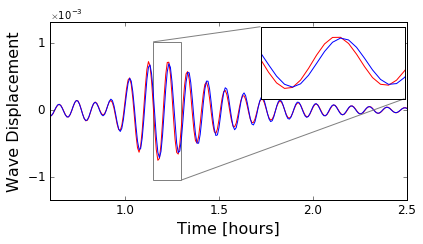

In [135]:
src=5
data = fitsread(os.path.join(datadir,"data",str(src).zfill(2)+".fits"))
vzcc = fitsread(os.path.join(datadir,"tt","iter00","vz_cc_src{:02d}.fits".format(src)))
fmode_filter = fitsread('fmode_filter.fits')

data = np.fft.ifft2(np.fft.fft2(data)*fmode_filter).real
vzcc = np.fft.ifft2(np.fft.fft2(vzcc)*fmode_filter).real
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

nt = data.shape[0]
t = np.arange(nt)*dt/60**2

plt.plot(t,data[:,nx//2+20],color="red")
plt.plot(t,vzcc[:,nx//2+20],color="blue")
ax=plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
ax.yaxis.get_major_formatter().set_powerlimits((0,0))
plt.xlim(0.6,2.5)
plt.xlabel("Time [hours]",fontsize=16)
plt.ylabel("Wave Displacement",fontsize=16)
plt.tick_params(labelsize=12)
plt.margins(y=0.4)

axins = inset_axes(ax, 2,1 , loc=2,bbox_to_anchor=(0.6, 0.9),bbox_transform=ax.figure.transFigure)
axins.plot(t,data[:,nx//2+20],color="red")
axins.plot(t,vzcc[:,nx//2+20],color="blue")
plt.xlim(1.15,1.3)
axins.xaxis.set_major_locator(ticker.NullLocator())
axins.yaxis.set_major_locator(ticker.NullLocator())
plt.margins(y=0.2)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5");

plt.gcf().set_size_inches(6,3.5)
plt.tight_layout()

if not os.path.exists("plots"): os.makedirs("plots")
plt.savefig(os.path.join("plots","tt_shift.eps"))

### Schematic shifted waves

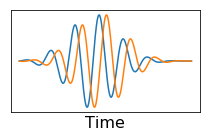

In [19]:
def f(t,t0):
    sigma=1
    omega=1
    return np.exp(-(t-t0)**2/(2*sigma**2))*np.sin(2*np.pi*omega*(t-t0))

t_plot=np.linspace(0,7,500)

plt.plot(t_plot,f(t_plot,3))
plt.plot(t_plot,f(t_plot,3.3))

for ax in [plt.gca().xaxis,plt.gca().yaxis]:
    ax.set_major_locator(ticker.NullLocator())
    
if not os.path.exists("plots"):
    os.makedirs("plots")
    
plt.xlabel("Time",fontsize=16)
plt.gcf().set_size_inches(3,2)
plt.tight_layout()
plt.savefig("plots/shifted_waves_schematic.eps")